<a href="https://colab.research.google.com/github/cfitzpatrick89/ADS509-Final/blob/main/FinalProject_ADS509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import xmltodict
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import json
from sklearn.decomposition import NMF
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models
from sklearn.cluster import KMeans

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install xmltodict
# !pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Directory

In [3]:
# Function to create a directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pubmed IDs

In [4]:
# Function to fetch PubMed IDs based on a query and date range
def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Function to fetch details for PubMed IDs in batches
def fetch_pubmed_details(ids, batch_size=100):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Extract and Parse Data

In [6]:
# Function to extract text from abstract field in different formats
def extract_text_from_abstract(abstract):
    print(f"Extracting text from abstract: {abstract}")  # Debug statement
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        extracted_text = ' '.join(text_list)
    elif isinstance(abstract, dict):
        extracted_text = abstract.get('#text', '')
    else:
        extracted_text = abstract
    print(f"Extracted text: {extracted_text[:60]}...")  # Debug statement
    return extracted_text

# Function to parse PubMed XML Data in batches
def parse_pubmed_details(xml_data_list):
    articles = []
    for batch_index, xml_data in enumerate(xml_data_list):
        try:
            print(f"Parsing batch {batch_index + 1}/{len(xml_data_list)}")  # Debug statement
            data_dict = xmltodict.parse(xml_data)
            for article in data_dict['PubmedArticleSet']['PubmedArticle']:
                try:
                    pmid = article['MedlineCitation']['PMID']
                    title = article['MedlineCitation']['Article']['ArticleTitle']
                    abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
                    abstract_text = extract_text_from_abstract(abstract)
                    articles.append({
                        'PMID': pmid,
                        'Title': title,
                        'Abstract': abstract_text
                    })
                    print(f"Article parsed: PMID {pmid}, Title {title[:60]}...")  # Debug statement
                except KeyError as e:
                    print(f"KeyError: {e} - Skipping article")  # Debug statement
                    continue
        except Exception as e:
            print(f"Error parsing XML: {e} - Skipping batch")  # Debug statement
            continue
    return articles



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocess Text

In [7]:
# Function to preprocess text
def preprocess_text(text):
    print(f"Preprocessing text: {text[:60]}...")  # Print the first 60 characters of the text for debugging
    tokens = word_tokenize(text)  # Tokenize the text
    print(f"Tokens: {tokens[:10]}...")  # Print the first 10 tokens for debugging
    tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
    print(f"Lowercased Tokens: {tokens[:10]}...")  # Print the first 10 lowercased tokens for debugging
    tokens = [word for word in tokens if word.isalpha()]  # Remove tokens that contain non-alphabetic characters
    print(f"Alphabetic Tokens: {tokens[:10]}...")  # Print the first 10 alphabetic tokens for debugging
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    print(f"Tokens without Stopwords: {tokens[:10]}...")  # Print the first 10 tokens without stopwords for debugging
    return tokens



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic Modeling NMF

In [14]:
%matplotlib inline

def nmf_topic_modeling(df_articles, num_topics=5):
    # Use TF-IDF to find important terms
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df_articles['processed_abstract_str'])

    # Apply NMF for topic modeling
    nmf = NMF(n_components=num_topics, random_state=42)
    W = nmf.fit_transform(X)
    H = nmf.components_

    # Display and visualize topics
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(H):
        print(f"Topic #{topic_idx}:")
        top_terms = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        print(" ".join(top_terms))

# Plot the top terms
        top_term_weights = topic[topic.argsort()[:-10 - 1:-1]]
        plt.figure(figsize=(10, 6))
        plt.barh(top_terms, top_term_weights, color='skyblue')
        plt.xlabel('Weight')
        plt.title(f'Top Terms for Topic #{topic_idx}')
        plt.gca().invert_yaxis()
        plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Topic Modeling LDA

In [9]:
def lda_topic_modeling(df_articles, num_topics=5):
    processed_docs = df_articles['processed_abstract'].tolist()
    dictionary = corpora.Dictionary(processed_docs)
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
    lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Sentiment Analysis

In [10]:
def sentiment_analysis(df_articles):
    sid = SentimentIntensityAnalyzer()
    df_articles['sentiment'] = df_articles['Abstract'].apply(lambda x: sid.polarity_scores(x)['compound'])
    plt.figure(figsize=(12, 6))
    sns.histplot(df_articles['sentiment'], bins=20, kde=True)
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Directory 'ingested_data' already exists.
Fetched 100 PubMed IDs.
Fetched PubMed details.
Parsing batch 1/1
Extracting text from abstract: In this overview, we articulate research needs and opportunities in the field of infection prevention that have been identified from insights gained during operative infection prevention work, our own research in healthcare epidemiology, and from reviewing the literature. The 10 areas of research need are: 1) Transmissions and interruptions, 2) personal protective equipment and other safety issues in occupational health, 3) climate change and other crises, 4) device, diagnostic, and antimicrobial stewardship, 5) implementation and deimplementation, 6) healthcare outside the acute care hospital, 7) low- and middle-income countries, 8) networking with the "neighbors," 9) novel research methodologies, and 10) the future state of surveillance. An introduction and chapters 1-5 are presented in part I of the article and chapters 6-10 and the discussion in

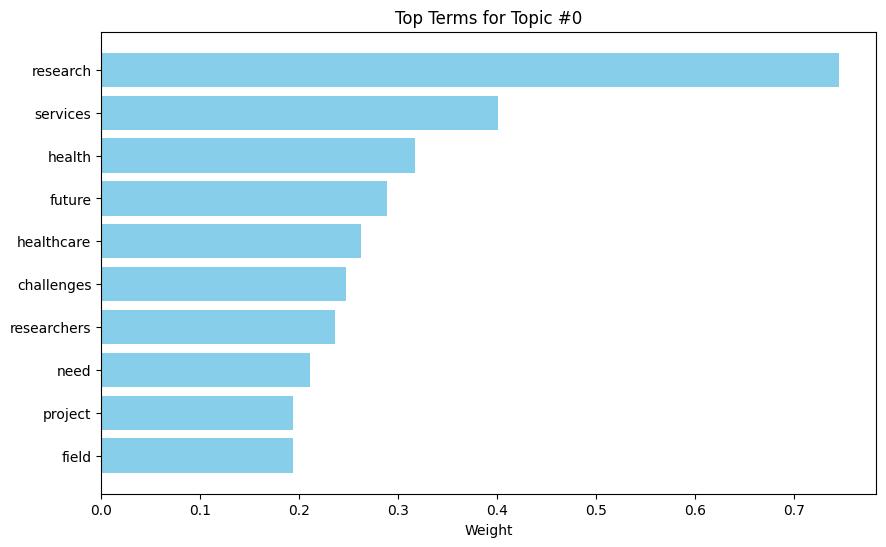

Topic #1:
heat temperature mortality days exposure risk dtr extreme waves cold


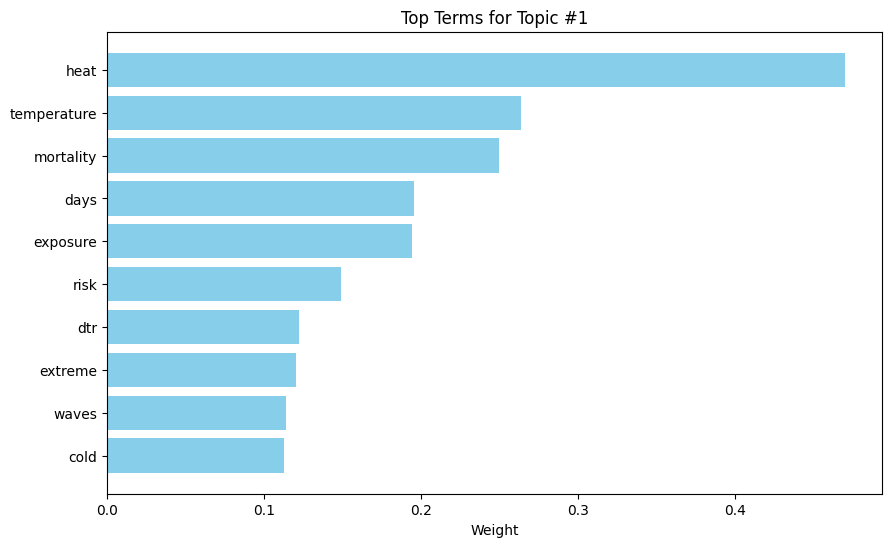

Topic #2:
compounds soil plant agricultural se control crops improve resistance extract


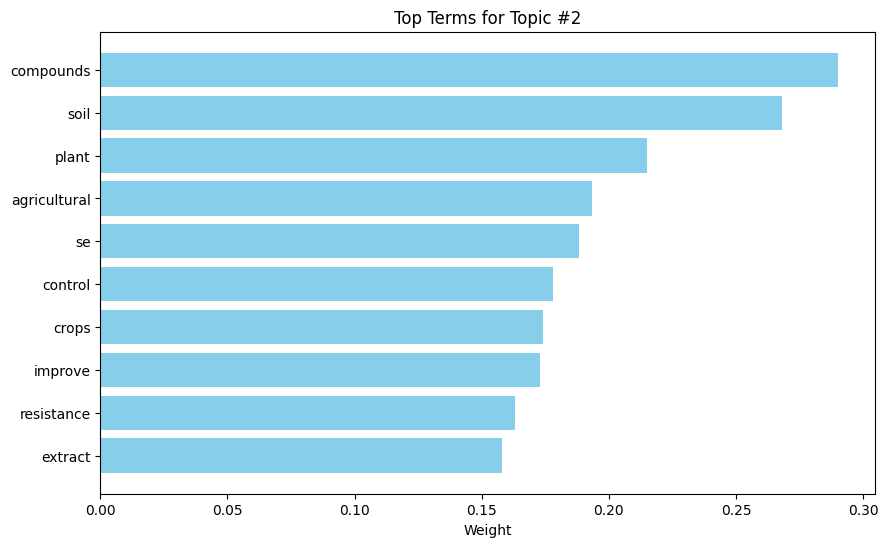

Topic #3:
virus vbvds diagnosis iran samples arboviruses rna assays new diagnostic


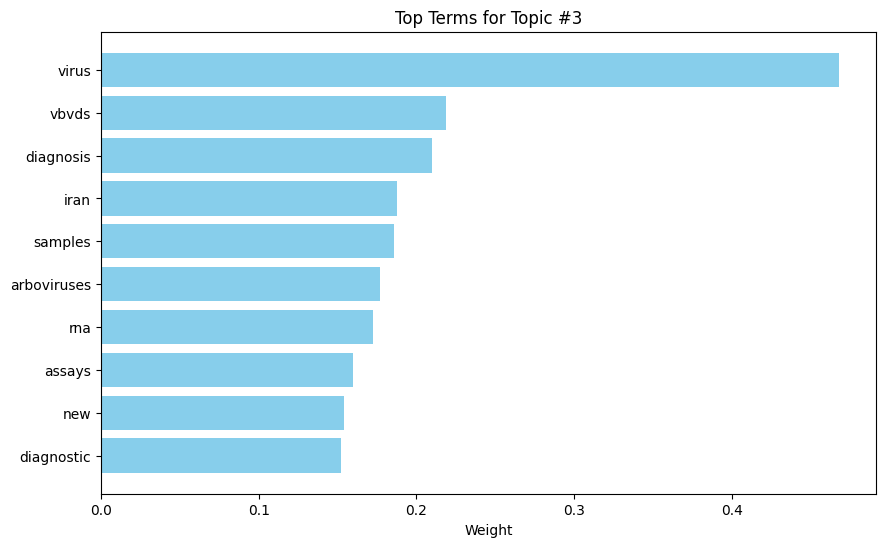

Topic #4:
physical activity climate sleep change actions articles warmer behaviors winter


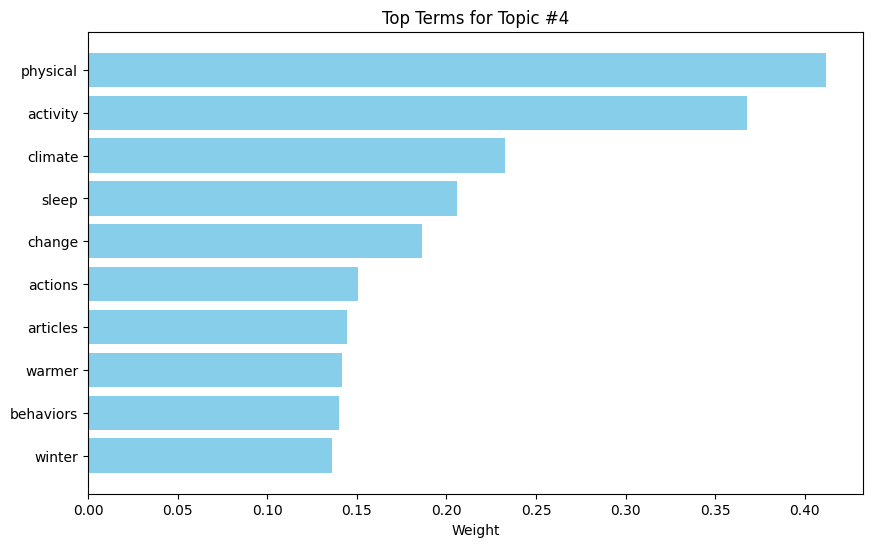

LDA Topic Modeling:
Sentiment Analysis:


LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [11]:
def main_function():
    # Create a directory for ingested data
    data_directory = "ingested_data"
    create_directory(data_directory)

    # Fetch PubMed IDs
    pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')
    print(f"Fetched {len(pubmed_ids)} PubMed IDs.")

    if pubmed_ids:
        # Fetch details for each PubMed ID in batches
        pubmed_xml_list = fetch_pubmed_details(pubmed_ids)
        print("Fetched PubMed details.")

        # Parse the details from each batch
        articles = parse_pubmed_details(pubmed_xml_list)
        print(f"Parsed {len(articles)} articles.")
        for article in articles[:5]:  # Print the first 5 articles for debugging
            print(f"PMID: {article['PMID']}, Title: {article['Title']}, Abstract: {article['Abstract'][:60]}...")

        # Convert to DataFrame
        df_articles = pd.DataFrame(articles)
        print("Converted articles to DataFrame.")
        print(df_articles.head())  # Print first few rows of DataFrame to check the data

        # Apply preprocessing to articles' abstracts
        if not df_articles.empty:
            df_articles['processed_abstract'] = df_articles['Abstract'].apply(lambda x: preprocess_text(x))
            # Join tokens back to strings for TF-IDF processing
            df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))

            print("Preprocessed abstracts:")
            print(df_articles[['Abstract', 'processed_abstract_str']].head())

            # NMF Topic Modeling
            print("NMF Topic Modeling:")
            nmf_topic_modeling(df_articles)

            # LDA Topic Modeling
            print("LDA Topic Modeling:")
            lda_topic_modeling(df_articles)

            # Sentiment Analysis
            print("Sentiment Analysis:")
            sentiment_analysis(df_articles)

        else:
            print("No articles were parsed.")
    else:
        print("No articles were fetched.")

if __name__ == "__main__":
    main_function()

